In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from pprint import pprint
from IPython.display import display
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import h5py
from sklearn.model_selection import train_test_split

import torch
torch.set_default_dtype(torch.float64)

import e3nn
import e3nn.point.data_helpers as dh 
from training_utils import *

In [3]:
# make sure CUDA is available
print(torch.cuda.current_device())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())
print(torch.version.cuda)
device = "cuda"
#torch.rand(10).to(device)
#torch.rand(10, device=device)

0
1
Tesla V100-PCIE-32GB
True
10.1


In [4]:
relevant_elements = { "H", "C" }                            # only train on the shieldings at these elements
elementwide_scaling_factors = {"C":5.0, "H":1.5, "O":50.0}  # divide absolute shieldings by these numbers
n_elements = len(elementwide_scaling_factors)
all_elements = list(elementwide_scaling_factors.keys())

In [5]:
# represents the training data for one molecule
class Molecule():
    def __init__(self, name,               # name of molecule
                 atomic_symbols,           # vector of strings of length n_atoms
                 symmetrical_atoms,        # list of lists of 0-indexed atom numbers
                 stationary_shieldings,    # vector of floats of length n_atoms
                 geometries,               # (n_examples, n_atoms, 3)
                 perturbed_shieldings):    # (n_examples, n_atoms, 1) 
        self.name = name                                       
        self.stationary_shieldings = stationary_shieldings
        self.geometries = geometries                                               
        self.atomic_symbols = atomic_symbols
        self.n_atoms = len(atomic_symbols)
  
        # rescale shieldings for training
        perturbed_shieldings = perturbed_shieldings - stationary_shieldings
        scaling_factors = [ elementwide_scaling_factors[symbol] for symbol in atomic_symbols ]
        scaling_factors = np.array(scaling_factors)
        self.scaling_factors = scaling_factors
        perturbed_shieldings = perturbed_shieldings / scaling_factors
        self.perturbed_shieldings = perturbed_shieldings
        
        # compute features
        # one-hots for one example (since they're all the same): n_atoms, n_elements
        features = []
        for symbol in atomic_symbols:
            inner_list = [ 1. if symbol == i else 0. for i in all_elements ]
            features.append(inner_list)
        self.features = np.array(features)
    
        # compute per-atom weights for the loss function
        weights = [ 1.0 if symbol in relevant_elements else 0.0 for symbol in atomic_symbols ]
        weights = np.array(weights)
        for l in symmetrical_atoms:
            weight = 1.0/len(l)
            for i in l:
                weights[i] = weight
        self.weights = weights

In [13]:
# given a list of molecules, generate an MSE loss function that uses the weights:
def generate_loss_function(molecules):
    weights = [ m.weights for m in molecules ]
    weights = np.concatenate(weights)
    normalization = np.sum(weights)
    weights = torch.from_numpy(weights).to(device)
    normalization = torch.tensor([normalization]).to(device)
    def loss_function(predictions, data):
        predictions = output
        observations = data.y
        loss = (predictions-observations) * weights
        loss = loss.square().sum() / normalization
        loss = loss.sqrt()
        return loss
    return loss_function

In [14]:
molecules_dict = {}  # name -> Molecule

# read the training data
# iterate through the hdf5s (one per molecule)
for hdf5_filename in sorted(glob("*.hdf5")):
    with h5py.File(hdf5_filename, "r") as h5:
        name = h5.attrs.get("name")
        print(name)
        geometries_and_shieldings = np.array(h5.get("data"))
        geometries = geometries_and_shieldings[:,:,:3]
        perturbed_shieldings = geometries_and_shieldings[:,:,3]
        stationary_shieldings = np.array(h5.attrs.get("stationary"))
        atomic_symbols = list(h5.get("atomic_symbols"))
        atomic_symbols = [ symbol.decode("utf-8") for symbol in atomic_symbols ]
        n_atoms = len(atomic_symbols)

        # these are the 1-indexed atom numbers that are symmetrical
        group = h5.get("symmetrical_atoms")
        symmetrical_atoms = []  # 0-indexed
        for v in group.values():
            v = [ i-1 for i in v ]
            symmetrical_atoms.append(v)

        # store the results
        molecule = Molecule(name, atomic_symbols, symmetrical_atoms,
                            stationary_shieldings, geometries, perturbed_shieldings)
        molecules_dict[name] = molecule
        
molecules = np.array(list(molecules_dict.values()))

acetaldehyde
acetone
butanone
dimethyl_ether
ethane


In [15]:
# split into train/test molecules and generate functions for the training molecules
training_molecules = molecules[[0,1,3,4]]
testing_molecules = [molecules[2]]
loss_function = generate_loss_function(training_molecules)

In [16]:
# features are one-hots for every atom,
# so this is (number of one_hots, rank zero tensor, even parity)
Rs_in = [(n_elements,0,1)]

# we are outputing one scalar for every atom
# so this is (one, rank zero tensor, even parity)
Rs_out = [(1,0,1)]

# maximum extent of radial basis functions in Angstroms
max_radius = 4.0

In [17]:
# preprocess the neighbor information for the train and test sets
def create_torch_datasets(molecules, train_size, test_size, random_state):
    training_dataset = []
    testing_dataset = []
    for molecule in molecules:
        print(f"Preprocessing {molecule.name} data:")
        train_geometries, test_geometries, train_shieldings, test_shieldings = train_test_split(
                                                              molecule.geometries,
                                                              molecule.perturbed_shieldings,
                                                              train_size=train_size, test_size=test_size,
                                                              random_state=random_state)
        train_test = [(train_geometries,train_shieldings,training_dataset),
                      (test_geometries,test_shieldings,testing_dataset)]
        features = torch.tensor(molecule.features, dtype=torch.float64)
        weights = torch.tensor(molecule.weights, dtype=torch.float64) 
        i = 0
        n_to_save = len(train_geometries) + len(test_geometries)
        for geometries, shieldings, target in train_test:
            for g,s in zip(geometries,shieldings):
                g = torch.tensor(g, dtype=torch.float64)
                s = torch.tensor(s, dtype=torch.float64).unsqueeze(-1)  # [1,N]
                data = dh.DataNeighbors(x=features, Rs_in=Rs_in, pos=g, r_max=max_radius,
                                        self_interaction=True, name=molecule.name,
                                        weights=weights, y=s, Rs_out = Rs_out)
                target.append(data)
                i += 1
                if (i+1) % 100 == 0:
                    print(f"{i+1:10d} of {n_to_save:10d}...", end="\r", flush=True)
                if i == n_to_save - 1:
                    print(f"{i+1:10d} of {n_to_save:10d}               done!")
    return training_dataset, testing_dataset

In [29]:
training_dataset, test_dataset = create_torch_datasets(training_molecules,
                                                       train_size = 10000,
                                                       test_size = 5000,
                                                       random_state = 1)
_, final_testing_dataset = create_torch_datasets(testing_molecules,
                                                 train_size = 1,
                                                 test_size = 5000,
                                                 random_state = 1)

Preprocessing acetaldehyde data:
     15000 of      15000               done!
Preprocessing acetone data:
     15000 of      15000               done!
Preprocessing dimethyl_ether data:
     15000 of      15000               done!
Preprocessing ethane data:
     15000 of      15000               done!
Preprocessing butanone data:
      5001 of       5001               done!


In [30]:
# define the neural network architecture
model_kwargs = {
    'network': 'GatedConvParityNetwork', 
    'conv': 'Convolution',
    'Rs_in': Rs_in,            # shape of inputs
    'Rs_out': Rs_out,          # shape of outputs
    'mul': 5,                 # how many copies of each tensor at each layer
    'lmax': 1,                 # maximum angular momentum
    'layers': 5,               # number of layers
    'max_radius': max_radius,  # radial kernel will extend out this far
    'number_of_basis': 30,     # number of Gaussians in radial kernel
}
model = model_from_kwargs(model_kwargs)

In [31]:
# training parameters
learning_rate = 3e-3
opt = torch.optim.Adam(model.parameters(), learning_rate)
max_iter = 100       
n_norm = 5           # n_norm is average number of convolution neighbors per atom
batch_size = 100
training_size = len(training_dataset)
training_dataloader = tg.data.DataListLoader(training_dataset, batch_size=batch_size, shuffle=True)

In [32]:
# train model 
model.to(device)
n_batches = int(training_size / batch_size)
for i in range(max_iter):
    start_time = time.time()
    loss_cum = torch.tensor([0.]).to(device)
    for j,data in enumerate(training_dataloader):
        print(f"Iteration {i+1:5d}    batch {j+1:5d} / {n_batches:5d}", end="\r", flush=True)
        data = tg.data.Batch.from_data_list(data)
        data.to(device)
        output = model(data.x, data.edge_index, data.edge_attr, n_norm=n_norm)
        #print(output)
        loss = loss_function(output, data)
        #print(loss)
        loss_cum += loss
        opt.zero_grad()
        loss.backward()
        opt.step()
    end_time = time.time()
    elasped_time = end_time - start_time
    print(f"Iteration {i+1:5d}    batch {j+1:5d} / {n_batches:5d}  loss = {loss_cum.item() / (j+1):9.6f}    elapsed = {elasped_time:7.2f} s")
    #break

Iteration     1    batch  2000 /  2000  loss =  3.962497    elapsed =  120.05 s


KeyboardInterrupt: 

In [26]:
# test the model as it now
torch.cuda.empty_cache()
model.to(device)
testing_dataloader = tg.data.DataListLoader(test_dataset, batch_size=batch_size, shuffle=True)
testing_size = len(test_dataset)
n_batches = int(testing_size / batch_size)
results_dict = {} # molecule name -> residuals (n_examples,n_atoms)
start_time = time.time()

loss_cum = torch.tensor([0.]).to(device)
for j,data in enumerate(testing_dataloader):
    print(f"batch {j+1:5d} / {n_batches:5d}", end="\r", flush=True)
    data = tg.data.Batch.from_data_list(data)
    data.to(device)
    with torch.no_grad():
        output = model(data.x, data.edge_index, data.edge_attr, n_norm=n_norm)
        residuals = output - data.y
        residuals = residuals.squeeze(-1).cpu().numpy()
        i=0
        for name in data.name:
            molecule = molecules_dict[name]
            n_atoms = molecule.n_atoms
            scaling_factors = molecule.scaling_factors
            if name not in results_dict:
                results_dict[name] = []
            subset = residuals[i:i+n_atoms] * scaling_factors
            results_dict[name].append(subset)
            i += n_atoms
        loss = loss_function(output, data)
    loss_cum += loss
loss_cum = loss_cum/(j+1)
end_time = time.time()
elasped_time = end_time - start_time
print(f"\nOverall loss is {loss_cum.item():.6f}.  Evaluation took {elasped_time:.2f} s.")

batch   100 /   100
Overall loss is 1.999474.  Evaluation took 3.01 s.


In [27]:
# reshape residual data
results_dict2 = {}
for name,results in results_dict.items():
    results = np.array(results).T
    molecule = molecules_dict[name]
    atomic_symbols = molecule.atomic_symbols
    for i,v in enumerate(results):
        element = atomic_symbols[i]
        if element not in relevant_elements:
            continue
        label = f"{name}_{element}{i+1}"
        results_dict2[label]=v

In [28]:
# summary stats
df = pd.DataFrame(results_dict2)
means = df.mean()
ranges = df.max()-df.min()
RMSEs = df.pow(2).mean()
df = pd.concat([means,ranges,RMSEs], axis=1)
df.columns = ["mean","range","RMSE"]
df = df.round(2)
display(df)

,mean,range,RMSE
ethane_C1,-0.19,8.43,1.15
ethane_H2,-0.00,0.89,0.01
ethane_H3,0.00,0.99,0.01
ethane_H4,-0.01,1.05,0.02
ethane_C5,-0.17,7.47,1.07
ethane_H6,-0.01,0.92,0.01
ethane_H7,-0.00,0.91,0.02
ethane_H8,-0.01,1.15,0.01
dimethyl_ether_C1,0.03,11.22,1.27
dimethyl_ether_H2,0.05,1.18,0.04


In [ ]:
# 
def save_dataset(geometry_subset, shielding_subset, features_subset, output_filename):
    dataset = []
    n_to_save = len(geometry_subset)
    print(f"Preprocessing for {output_filename}:")
    for i,(g,s,f) in enumerate(zip(geometry_subset, shielding_subset, feature_subset)):
        g,s,f = torch.tensor(g, dtype=torch.float64), torch.tensor(s, dtype=torch.float64).unsqueeze(-1), torch.tensor(f, dtype=torch.float64)
        data = DataNeighborsSelection(x=f, Rs_in=Rs_in, pos=g, r_max=max_radius,
                                      atomic_numbers=atomic_numbers, relevant_atomic_numbers=relevant_atomic_numbers,
                                      y=s, Rs_out=Rs_out)
        dataset.append(data)
        if (i+1) % 100 == 0 or i == n_to_save - 1:
            print(f"{i+1:10d} of {n_to_save:10d}...", end="\r", flush=True)
    print("\nWriting to disk...", end="", flush=True)
    torch.save(dataset, output_filename)
    print(f"done.  Saved {len(dataset)} records.")

In [ ]:
class DataNeighborsSelection(dh.DataNeighbors):
    # this class precomputes data for one training or test example
    # x              : features (one-hots)
    # Rs_in          : input classification [(number of tensors, tensor_rank, parity)
    # pos            : geometry ([xyz])
    # atomic_symbols : list of strings
    # weights        : relative weight for RMSE calculation (deals with symmetrical atoms)
    def __init__(self, x, Rs_in, pos, r_max, atomic_symbols, weights, self_interaction=True, **kwargs):
        super().__init__(x, Rs_in, pos, r_max,
                         self_interaction=self_interaction,
                         relevant_atom_indices=relevant_atom_indices,
                         weights=weights,
                         **kwargs)

In [ ]:
# 
def save_dataset(geometry_subset, shielding_subset, features_subset, output_filename):
    dataset = []
    n_to_save = len(geometry_subset)
    print(f"Preprocessing for {output_filename}:")
    for i,(g,s,f) in enumerate(zip(geometry_subset, shielding_subset, feature_subset)):
        g,s,f = torch.tensor(g, dtype=torch.float64), torch.tensor(s, dtype=torch.float64).unsqueeze(-1), torch.tensor(f, dtype=torch.float64)
        data = DataNeighborsSelection(x=f, Rs_in=Rs_in, pos=g, r_max=max_radius,
                                      atomic_numbers=atomic_numbers, relevant_atomic_numbers=relevant_atomic_numbers,
                                      y=s, Rs_out=Rs_out)
        dataset.append(data)
        if (i+1) % 100 == 0 or i == n_to_save - 1:
            print(f"{i+1:10d} of {n_to_save:10d}...", end="\r", flush=True)
    print("\nWriting to disk...", end="", flush=True)
    torch.save(dataset, output_filename)
    print(f"done.  Saved {len(dataset)} records.")

In [262]:
# features are one-hots for every atom,
# so this is (number of one_hots, rank zero tensor, even parity)
Rs_in = [(n_one_hots,0,1)]

# we are outputing one scalar for every atom
# so this is (one, rank zero tensor, even parity)
Rs_out = [(1,0,1)]

# maximum extent of radial basis functions in Angstroms
max_radius = 2.0

In [264]:
# save a subset of the data to a .torch file
# precompute the relevant neighbors
relevant_atomic_numbers = [1, 6]

def save_dataset(geometry_subset, shielding_subset, feature_subset, output_filename):
    dataset = []
    n_to_save = len(geometry_subset)
    print(f"Preprocessing for {output_filename}:")
    for i,(g,s,f) in enumerate(zip(geometry_subset, shielding_subset, feature_subset)):
        g,s,f = torch.tensor(g, dtype=torch.float64), torch.tensor(s, dtype=torch.float64).unsqueeze(-1), torch.tensor(f, dtype=torch.float64)
        data = DataNeighborsSelection(x=f, Rs_in=Rs_in, pos=g, r_max=max_radius,
                                      atomic_numbers=atomic_numbers, relevant_atomic_numbers=relevant_atomic_numbers,
                                      y=s, Rs_out=Rs_out)
        dataset.append(data)
        if (i+1) % 100 == 0 or i == n_to_save - 1:
            print(f"{i+1:10d} of {n_to_save:10d}...", end="\r", flush=True)
    print("\nWriting to disk...", end="", flush=True)
    torch.save(dataset, output_filename)
    print(f"done.  Saved {len(dataset)} records.")
    
# splits the dataset randomly into training and test sets
# train_size = # number of training examples
# test_size = # number of test examples
# prefix = filenames will start with this string
# random_state = for reproducible splits
def split_and_save(train_size, test_size, prefix, random_state):
    assert train_size + test_size <= n_examples
    #[ training_geometries, training_shieldings, training_features,
    #  testing_geometries, testing_shieldings, testing_features     ]
    splitting = train_test_split(geometries, shieldings, features,
                                test_size = test_size, train_size = train_size,
                                random_state = random_state, shuffle = True)
    save_dataset(*splitting[::2], f"{prefix}-train.torch")
    save_dataset(*splitting[1::2], f"{prefix}-test.torch")

In [266]:
train_size = 1000
test_size = 5000
split_and_save(train_size, test_size, "acetone-split1", 1)

Preprocessing for acetone-split1-train.torch:
      1000 of       1000...
Writing to disk...done.  Saved 1000 records.
Preprocessing for acetone-split1-test.torch:
      5000 of       5000...
Writing to disk...done.  Saved 5000 records.


In [267]:
dataset1 = torch.load("acetone-split1-train.torch")
dataset2 = torch.load("acetone-split1-test.torch")
batch_size = 50
train_dataloader = tg.data.DataListLoader(dataset1, batch_size=batch_size, shuffle=True)
test_dataloader = tg.data.DataListLoader(dataset2, batch_size=batch_size, shuffle=False)

In [268]:
# define the neural network architecture
model_kwargs = {
    'network': 'GatedConvParityNetwork', 
    'conv': 'Convolution',
    'Rs_in': Rs_in,            # shape of inputs
    'Rs_out': Rs_out,          # shape of outputs
    'mul': 5,                 # how many copies of each tensor at each layer
    'lmax': 1,                 # maximum angular momentum
    'layers': 5,               # number of layers
    'max_radius': max_radius,  # radial kernel will extend out this far
    'number_of_basis': 10,     # number of Gaussians in radial kernel
}
model = model_from_kwargs(model_kwargs)

In [269]:
# training parameters
learning_rate = 3e-3
opt = torch.optim.Adam(model.parameters(), learning_rate)
max_iter = 100       
n_norm = 5           # n_norm is average number of convolution neighbors per atom

In [270]:
def loss_function(output, data):
    index = data.relevant_atom_index
    predictions = output[index]
    observations = data.y[index]
    loss = (predictions-observations).square().mean()
    return loss

In [271]:
model.to(device)
n_batches = int(train_size / batch_size)
for i in range(max_iter):
    start_time = time.time()
    loss_cum = torch.tensor(0.)
    for j,data in enumerate(train_dataloader):
        print(f"Iteration {i+1:5d}    batch {j+1:5d} / {n_batches:5d}", end="\r", flush=True)
        data = tg.data.Batch.from_data_list(data)
        data.to(device)
        output = model(data.x, data.edge_index, data.edge_attr, n_norm=n_norm)
        loss = loss_function(output, data)
        loss_cum += loss
        opt.zero_grad()
        loss.backward()
        opt.step()
    end_time = time.time()
    elasped_time = end_time - start_time
    print(f"Iteration {i+1:5d}    batch {j+1:5d} / {n_batches:5d}  loss = {loss_cum.data / (j+1):7.6f}    elapsed = {elasped_time:7.2f} s")
    #break

Iteration     1    batch    20 /    20  loss = 0.542264    elapsed =    4.25 s
Iteration     2    batch    20 /    20  loss = 0.183491    elapsed =    4.25 s
Iteration     3    batch    20 /    20  loss = 0.102706    elapsed =    4.22 s
Iteration     4    batch    20 /    20  loss = 0.040474    elapsed =    4.24 s
Iteration     5    batch    20 /    20  loss = 0.030098    elapsed =    4.23 s
Iteration     6    batch    20 /    20  loss = 0.029470    elapsed =    4.25 s
Iteration     7    batch    20 /    20  loss = 0.025776    elapsed =    4.22 s
Iteration     8    batch    20 /    20  loss = 0.022495    elapsed =    4.23 s
Iteration     9    batch    20 /    20  loss = 0.021087    elapsed =    4.23 s
Iteration    10    batch    20 /    20  loss = 0.021325    elapsed =    4.22 s
Iteration    11    batch    20 /    20  loss = 0.020373    elapsed =    4.21 s
Iteration    12    batch    20 /    20  loss = 0.018608    elapsed =    4.23 s
Iteration    13    batch    20 /    20  loss = 0.019

In [272]:
# test the model as it now
torch.cuda.empty_cache()
model.to(device)
n_batches = int(test_size / batch_size)
start_time = time.time()

predictions = []
observations = []

loss_cum = torch.tensor(0.)
for j,data in enumerate(test_dataloader):
    print(f"batch {j+1:5d} / {n_batches:5d}", end="\r", flush=True)
    data = tg.data.Batch.from_data_list(data)
    data.to(device)
    with torch.no_grad():
        output = model(data.x, data.edge_index, data.edge_attr, n_norm=n_norm)
        predictions_this_batch = output.reshape((batch_size,n_atoms)).cpu().numpy()
        observations_this_batch = data.y.reshape((batch_size,n_atoms)).cpu().numpy()
        predictions.append(predictions_this_batch)
        observations.append(observations_this_batch)
        loss = loss_function(output, data)
    loss_cum += loss
loss_cum = loss_cum/(j+1)
end_time = time.time()
elasped_time = end_time - start_time
print(f"\nOverall loss is {loss_cum:.6f}.  Evaluation took {elasped_time:.2f} s.")
predictions = np.concatenate(predictions)
observations = np.concatenate(observations)

batch   100 /   100
Overall loss is 0.004969.  Evaluation took 6.06 s.


In [273]:
def undo_scaling(v):
    return v * stdevs + means
    #return v * widths + isotropic_shieldings
unscaled_predictions = undo_scaling(predictions)
unscaled_observations = undo_scaling(observations)
residuals = unscaled_predictions - unscaled_observations
print(np.shape(residuals))

(5000, 10)


In [274]:
relevant_atomic_numbers = [1, 6]  
relevant_atom_index = [i for i, atom_number in enumerate(atomic_numbers)
                               if atom_number in relevant_atomic_numbers]
print(relevant_atom_index)

[0, 2, 3, 4, 5, 6, 7, 8, 9]


In [275]:
pd.set_option('precision',4)
df = pd.DataFrame(residuals, columns = [ f"{j}{i+1}" for i,j in enumerate(atomic_symbols) ] )
df = df.iloc[:,relevant_atom_index].copy()
display(df.head())

,C1,C3,H4,H5,H6,C7,H8,H9,H10
0,-1.5741,0.2285,-0.0594,-0.0581,0.1207,-0.2391,-0.0267,0.0043,0.0718
1,-0.7376,-0.0433,-0.0425,-0.0234,-0.0076,-0.2058,-0.0668,-0.0184,0.0018
2,0.3324,-0.2465,-0.0154,0.0007,-0.0147,-0.8282,-0.0572,-0.0630,-0.0416
3,-0.9387,0.6035,0.0082,-0.0075,-0.0343,0.1417,-0.0066,-0.0563,0.0416
4,0.2970,0.6079,0.1002,0.0320,-0.0202,-0.8104,0.0119,-0.0268,-0.0662


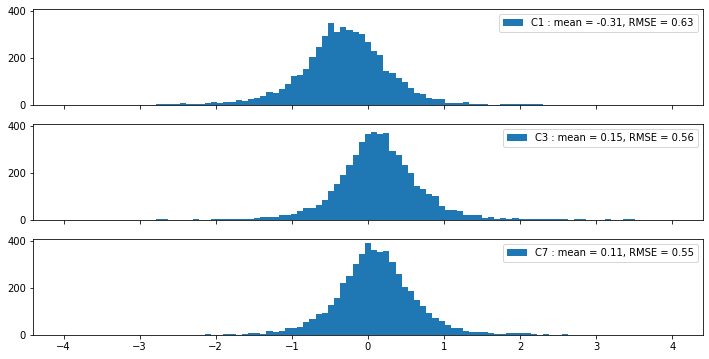

In [276]:
fig, axs = plt.subplots(3,1,sharex='col',sharey='col',figsize=(12,6))
bins = np.linspace(-4,4,100)
def plot(where, what):
    mean = what.mean()
    RMSE = np.sqrt(what.pow(2).mean())
    axs[where].hist(what, bins=bins, label=f"{what.name} : mean = {mean:.2f}, RMSE = {RMSE:.2f}")
    axs[where].legend(loc='upper right')
plot(0,df.C1)
plot(1,df.C3)
plot(2,df.C7)
plt.show()

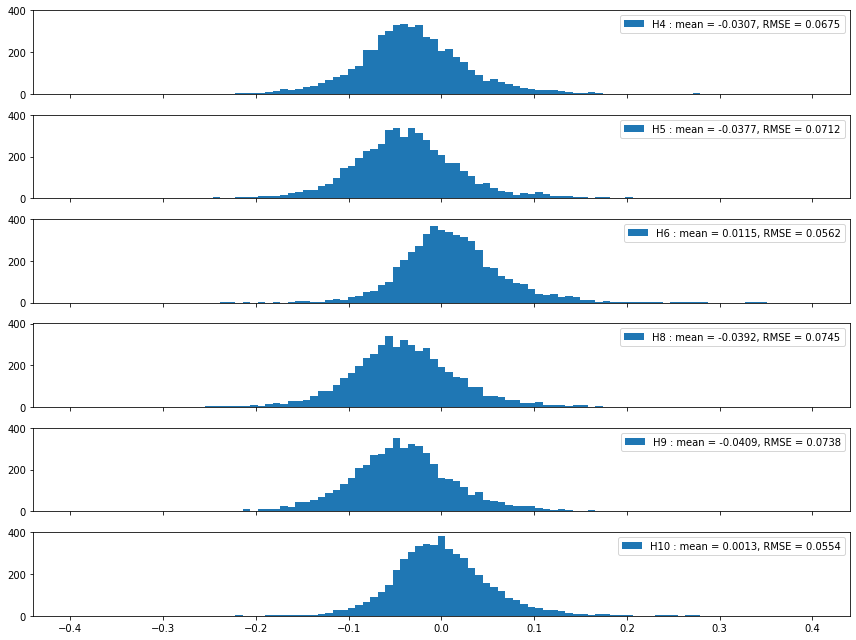

In [277]:
fig, axs = plt.subplots(6,1,sharex='col',sharey='col',figsize=(12,9))
bins = np.linspace(-0.4,0.4,100)
def plot(where, what):
    mean = what.mean()
    RMSE = np.sqrt(what.pow(2).mean())
    axs[where].hist(what, bins=bins, label=f"{what.name} : mean = {mean:.4f}, RMSE = {RMSE:.4f}")
    axs[where].legend(loc='upper right')
plot(0,df.H4)
plot(1,df.H5)
plot(2,df.H6)
plot(3,df.H8)
plot(4,df.H9)
plot(5,df.H10)
plt.tight_layout()
plt.show()